In [1]:
%matplotlib inline

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nighres.io import io_mesh
import gdist
from brainsmash.mapgen.memmap import txt2memmap
from brainsmash.mapgen.sampled import Sampled
from brainsmash.mapgen.eval import sampled_fit

In [3]:
data_dir = '/home/julia/data/gradients/'

### Create Geodesic distance map inside cortex mask

In [16]:
mesh = io_mesh.load_mesh(data_dir+'results/embedding/embed_sampled_mesh.vtk')
cortex = np.where(mesh['data'][:,0]!=0)[0]
np.save(data_dir+'results/null_models/surface/cortex_mask.npy', cortex)
np.save('/home/julia/data/gradients/results/null_models/surface/points.npy', mesh['points'])
np.save('/home/julia/data/gradients/results/null_models/surface/faces.npy', mesh['faces'])

In [18]:
cortex = np.load(data_dir+'results/null_models/surface/cortex_mask.npy')

In [ ]:
cortex = np.load(data_dir+'results/null_models/surface/cortex_mask.npy')
points = np.load(data_dir+'results/null_models/surface/points.npy')
faces = np.load(data_dir+'results/null_models/surface/faces.npy')

In [ ]:
for idx in range(cortex.shape[0]-1)
    dist = gdist.compute_gdist(np.array(points, dtype=np.float64),
                               np.array(faces, dtype=np.int32),
                               source_indices=np.array([cortex[idx]], dtype=np.int32),
                               target_indices=np.array(cortex[idx+1:], dtype=np.int32))

    np.save(data_dir+'results/null_models/surface/iter/idx_{}.npy'.format(idx), dist)

In [11]:
dist_matrix = np.zeros(shape=(cortex.shape[0],cortex.shape[0]))
for r in range(cortex.shape[0]-1):
    dist_matrix[r, r+1:] = np.load(data_dir+'results/null_models/surface/iter/idx_{}.npy'.format(r))
dist_matrix += dist_matrix.T

In [17]:
np.savetxt(data_dir+'results/null_models/surface/geodesic_dist_matrix.txt', dist_matrix)

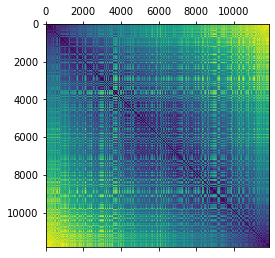

In [13]:
plt.matshow(dist_matrix)

### Create memory mapped arrays for surrogates

In [5]:
output_files = txt2memmap(data_dir+"results/null_models/surface/geodesic_dist_matrix.txt", 
                          data_dir+"results/null_models/surface/", 
                          maskfile=None, delimiter=' ')

In [22]:
gradients = io_mesh.load_mesh(data_dir+'results/embedding/embed_sampled_mesh.vtk')['data'][cortex][:,:6]

In [65]:
np.save(data_dir + 'results/embedding/gradients1_6.npy', gradients)

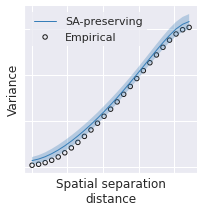

In [59]:
sns.set()
sampled_fit(gradients[:,0],
            data_dir+"results/null_models/surface/distmat.npy", 
            data_dir+"results/null_models/surface/index.npy",
            deltas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            ns=1000,
            knn=5000,
            nsurr=10)

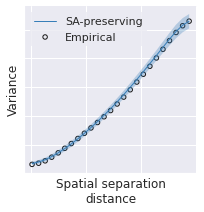

In [60]:
sns.set()
sampled_fit(gradients[:,1],
            data_dir+"results/null_models/surface/distmat.npy", 
            data_dir+"results/null_models/surface/index.npy",
            deltas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            ns=1000,
            pv=50,
            nsurr=10)

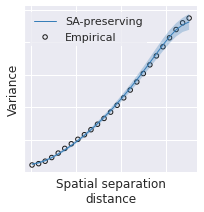

In [61]:
sns.set()
sampled_fit(gradients[:,2],
            data_dir+"results/null_models/surface/distmat.npy", 
            data_dir+"results/null_models/surface/index.npy",
            deltas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            ns=1000,
            nsurr=10)

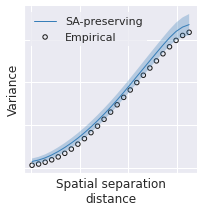

In [62]:
sns.set()
sampled_fit(gradients[:,3],
            data_dir+"results/null_models/surface/distmat.npy", 
            data_dir+"results/null_models/surface/index.npy",
            deltas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            ns=1000,
            knn=3000,
            nsurr=10)

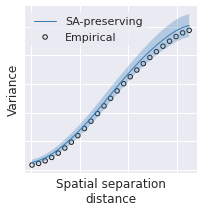

In [63]:
sns.set()
sampled_fit(gradients[:,4],
            data_dir+"results/null_models/surface/distmat.npy", 
            data_dir+"results/null_models/surface/index.npy",
            deltas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            ns=1000,
            knn=3000,
            nsurr=10)

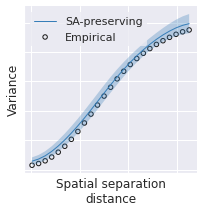

In [64]:
sns.set()
sampled_fit(gradients[:,5],
            data_dir+"results/null_models/surface/distmat.npy", 
            data_dir+"results/null_models/surface/index.npy",
            deltas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
            ns=1000,
            knn=3000,
            nsurr=10)

### Variogram of surrogates ran on cluster

In [88]:
emp_var = np.load(data_dir + 'results/null_models/surface/surf0_emp_var.npy').mean(axis=0)
surr_var = np.load(data_dir + 'results/null_models/surface/surf0_surr_var.npy')
u0 = np.load(data_dir + 'results/null_models/surface/surf0_u0.npy').mean(axis=0)

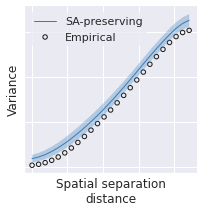

In [89]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.77])
ax.scatter(u0, emp_var, s=20, facecolor='none', edgecolor='k',
           marker='o', lw=1, label='Empirical')

mu = surr_var.mean(axis=0)
sigma = surr_var.std(axis=0)
ax.fill_between(u0, mu-sigma, mu+sigma, facecolor='#377eb8',
                edgecolor='none', alpha=0.3)
ax.plot(u0, mu, color='#377eb8', label='SA-preserving', lw=1)

leg = ax.legend(loc=0)
leg.get_frame().set_linewidth(0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.setp(ax.get_yticklabels(), visible=False)
plt.setp(ax.get_yticklines(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_xticklines(), visible=False)
ax.set_xlabel("Spatial separation\ndistance")
ax.set_ylabel("Variance")
plt.show()